In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scipy

In [2]:
import session_info
session_info.show()

In [8]:
sc.settings.set_figure_params(dpi=300)

# Read in

In [4]:
!ls /nfs/team205/heart/anndata_objects/Foetal/Immune

archive
C97_index.csv
MultiVI-model_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-0003
MultiVI-model_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-001
MultiVI-post_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-0003.h5ad
MultiVI-post_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-001.h5ad
MultiVI-pre_paired_foetal_MoMP_raw.h5ad
MultiVI-pre_scRNA_foetal_MoMP_raw.h5ad
RNA_foetal_raw_immune_16Feb2023.h5ad
RNA_foetal_raw_immune_16Feb2023_Multiome.h5ad
RNA_foetal_raw_immune_16Feb2023_Multiome.rds
RNA_foetal_raw_immune_16Feb2023.obs.csv
RNA_foetal_raw_Lymphoid_16Feb2023_CCregressed-scaled.h5ad
RNA_foetal_raw_Lymphoid_16Feb2023.h5ad
RNA_foetal_raw_Lymphoid_16Feb2023.obs.csv
RNA_foetal_raw_Myeloid_16Feb2023.h5ad
RNA_foetal_raw_Myeloid_16Feb2023.obs.csv
Tcycling


In [4]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/Immune/MultiVI-post_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-0003.h5ad')
adata

AnnData object with n_obs × n_vars = 7674 × 142283
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', '_indices', '_scvi_batch', '_scvi_labels', 'fine_grain_withcycling', 't', 'seg', 'edge', 't_sd'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'draw_graph', 'fine_grain_colors', 'fine_grain_withcycling_colors', 'graph', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors

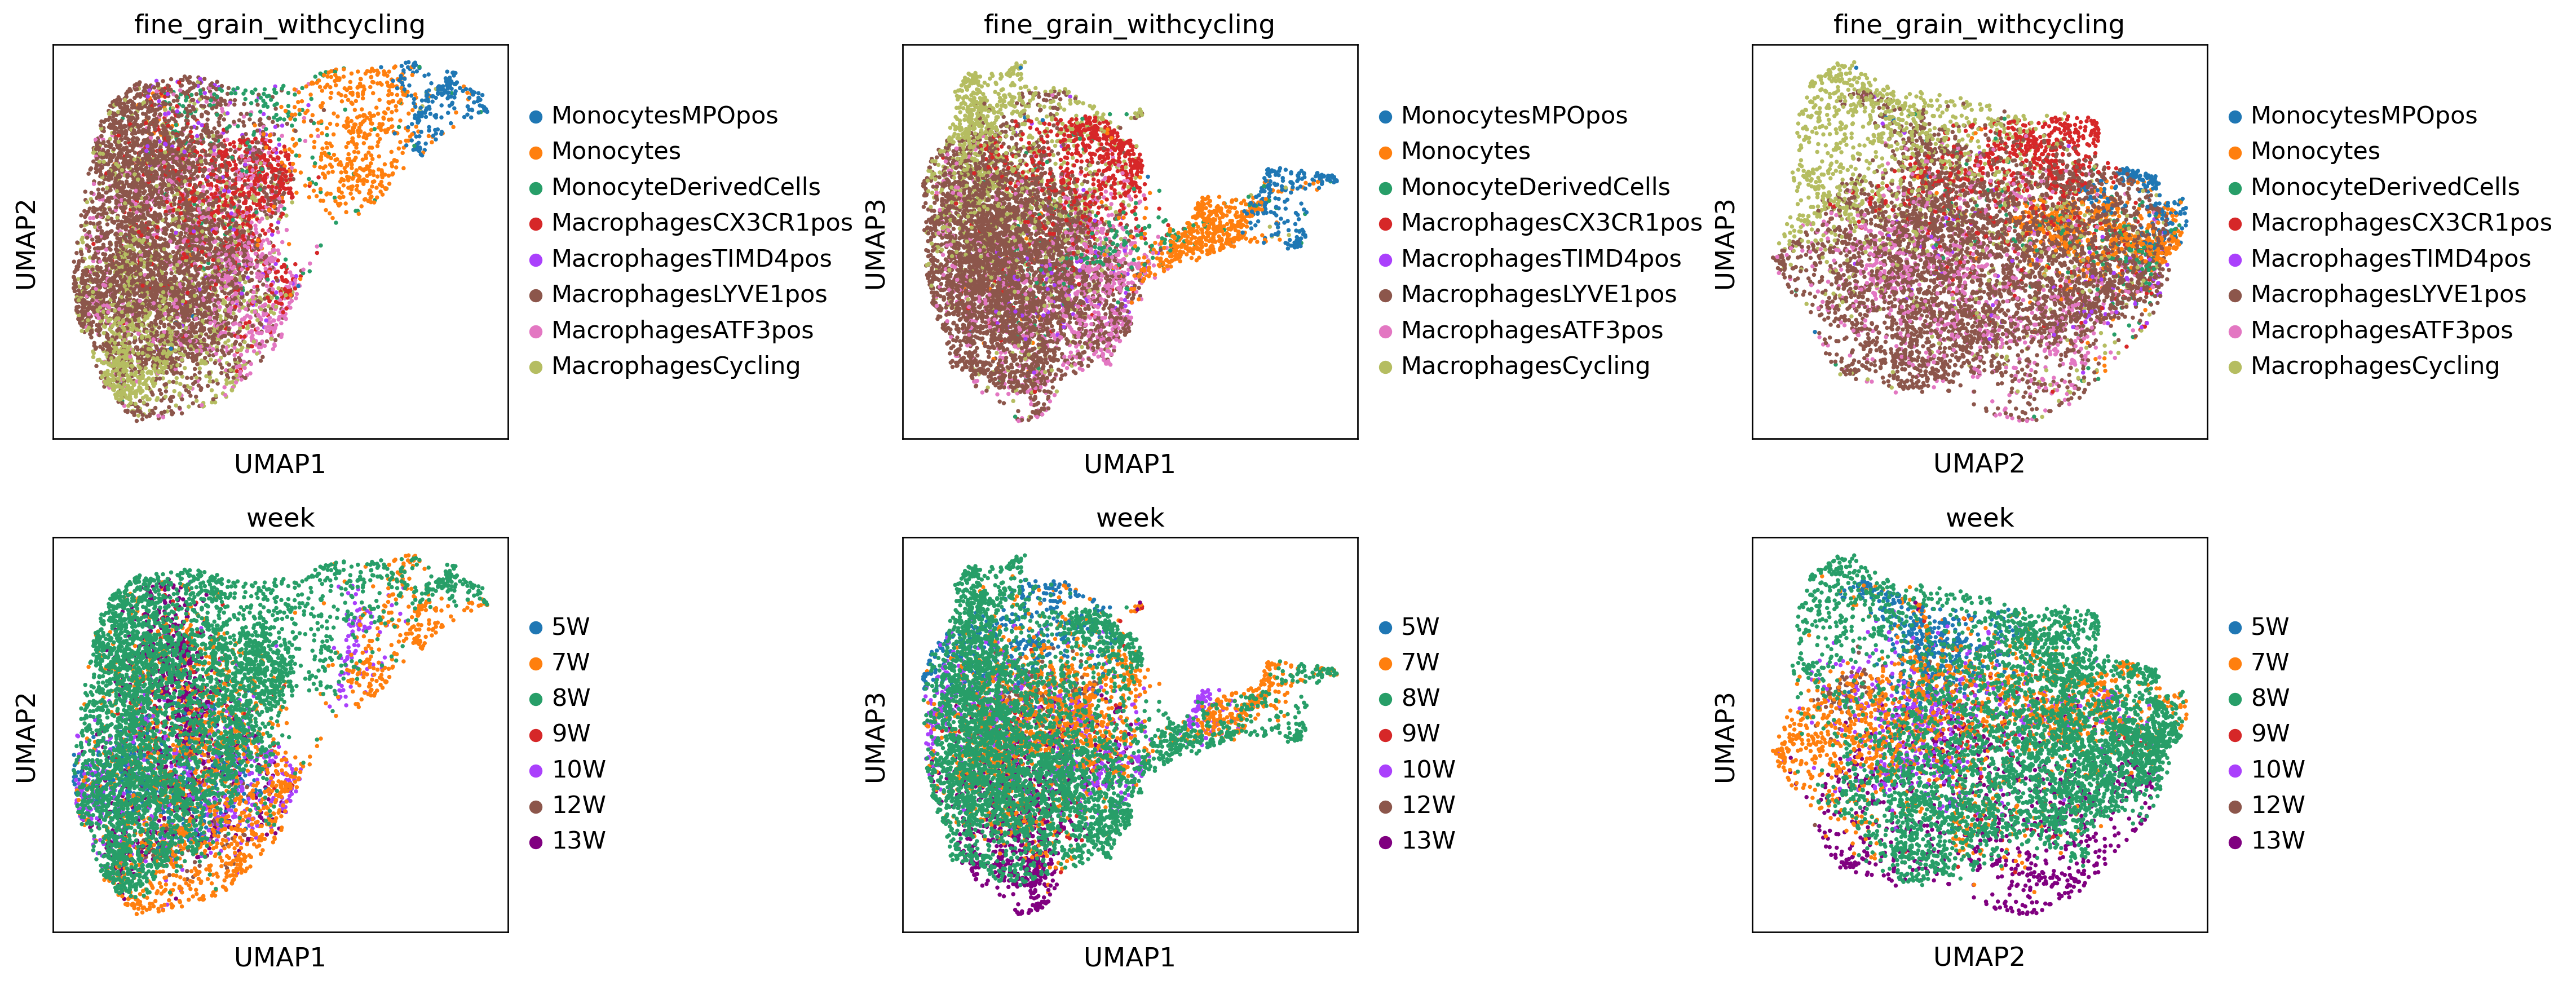

In [7]:
sc.pl.umap(adata, color=['fine_grain_withcycling','week'], size=20, wspace=0.7, components='all', ncols=3)

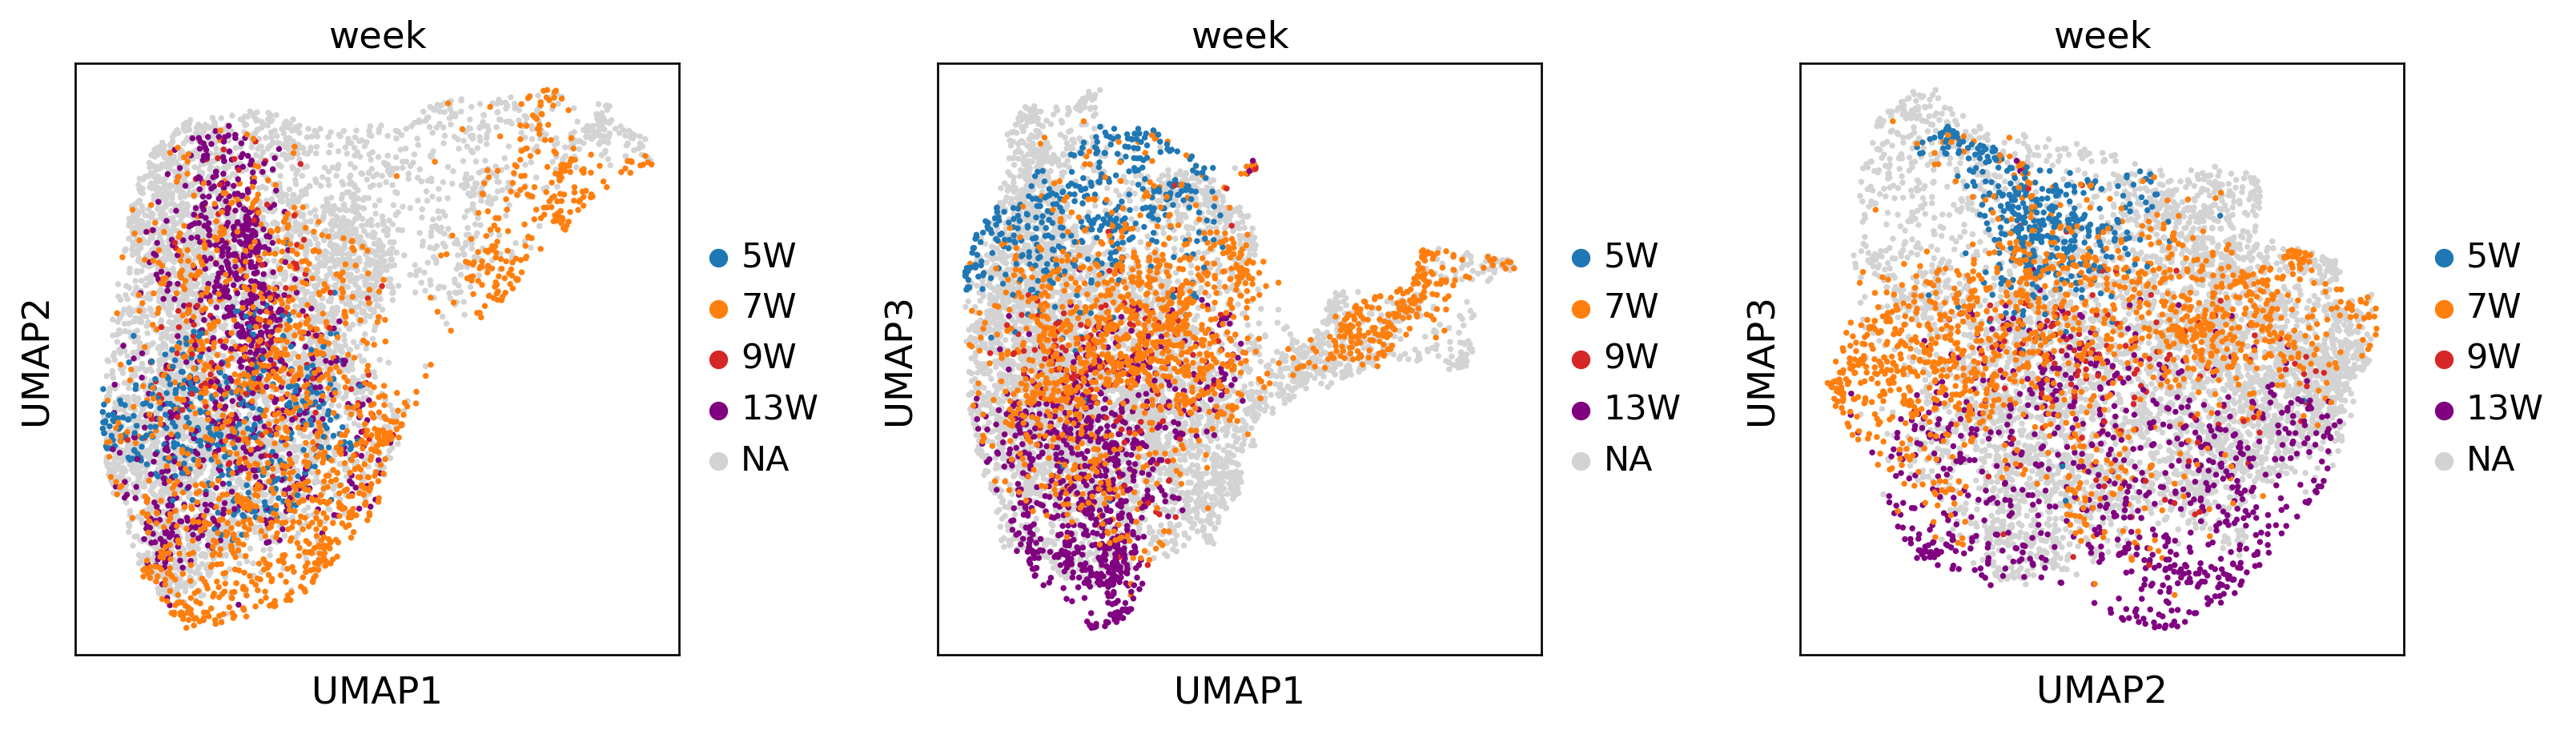

In [8]:
sc.pl.umap(adata, color=['week'], groups=['5W','7W','9W','13W'], size=20, wspace=0.3, components='all', ncols=3)

# scFates - Tree analysis

ref: https://scfates.readthedocs.io/en/latest/Tree_Analysis_Bone_marrow_fates.html

In [9]:
adata.var

modality gene_name_scRNA-0          gene_id  \
FUT8-AS1                  Gene Expression          FUT8-AS1  ENSG00000276116   
FUT8                      Gene Expression              FUT8  ENSG00000033170   
AL139022.1                Gene Expression        AL139022.1  ENSG00000259118   
MAX                       Gene Expression               MAX  ENSG00000125952   
FNTB                      Gene Expression              FNTB  ENSG00000257365   
...                                   ...               ...              ...   
chr5:173917443_173917943            Peaks               NaN              NaN   
chr5:177134858_177135358            Peaks               NaN              NaN   
chr5:177134341_177134841            Peaks               NaN              NaN   
chr5:177133469_177133969            Peaks               NaN              NaN   
chrX:155881618_155882118            Peaks               NaN              NaN   

                          n_cells  
FUT8-AS1                       55  
FUT8                         1093  
AL139022.1                     68  
MAX                          3491  
FNTB                          867  
...                           ...  
chr5:173917443_173917943      135  
chr5:177134858_177135358       30  
chr5:177134341_177134841      126  
chr5:177133469_177133969      506  
chrX:155881618_155882118       29  

[142283 rows x 4 columns]

In [10]:
import scFates as scf
import palantir

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


## Preprocessing pipeline from Palantir

### Create projection dataframe

* MultiVI latent space

In [11]:
projections = pd.DataFrame(adata.obsm["MultiVI_latent"],index=adata.obs_names)
projections

0         1   \
BHF_F_Hea11933668_BHF_F_Hea11596621_CATAGTCAGCA...  3.619392 -0.361971   
BHF_F_Hea11933669_BHF_F_Hea11596622_TTCGGTACAGC...  0.898537 -1.684821   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCATGCCTCGT...  3.412408  0.678513   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCTAATCTCCT...  2.879151  3.851903   
7089STDY13216927_BHF_F_Hea13242534_GTTTCTAGTCCT...  0.202437 -0.045277   
...                                                      ...       ...   
BHF_F_Hea11192328_AAGACCTCACACGCTG-1_expression     1.621205 -0.704967   
BHF_F_Hea11192328_CATATGGCAGCTCGCA-1_expression     1.081116  0.942422   
BHF_F_Hea11192328_CAACCAACACGCGAAA-1_expression     1.060063  1.397654   
BHF_F_Hea11192328_CATCAAGTCGTAGATC-1_expression    -2.260967  0.743850   
BHF_F_Hea11192328_GGATGTTGTGTTTGTG-1_expression    -1.180200  0.164727   

                                                          2         3   \
BHF_F_Hea11933668_BHF_F_Hea11596621_CATAGTCAGCA... -3.541048 -1.272431   
BHF_F_Hea11933669_BHF_F_Hea11596622_TTCGGTACAGC... -0.780915  0.657974   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCATGCCTCGT... -3.305515 -0.370856   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCTAATCTCCT... -1.701584  1.448535   
7089STDY13216927_BHF_F_Hea13242534_GTTTCTAGTCCT...  0.230007  0.223966   
...                                                      ...       ...   
BHF_F_Hea11192328_AAGACCTCACACGCTG-1_expression    -2.085282  0.962692   
BHF_F_Hea11192328_CATATGGCAGCTCGCA-1_expression    -0.806333  1.874006   
BHF_F_Hea11192328_CAACCAACACGCGAAA-1_expression    -0.491131  1.019970   
BHF_F_Hea11192328_CATCAAGTCGTAGATC-1_expression     1.969429 -1.591858   
BHF_F_Hea11192328_GGATGTTGTGTTTGTG-1_expression     1.488578  1.220757   

                                                          4         5   \
BHF_F_Hea11933668_BHF_F_Hea11596621_CATAGTCAGCA... -0.223910 -0.045747   
BHF_F_Hea11933669_BHF_F_Hea11596622_TTCGGTACAGC...  0.426351  1.032606   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCATGCCTCGT...  0.023855 -0.841828   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCTAATCTCCT...  1.978560 -1.367763   
7089STDY13216927_BHF_F_Hea13242534_GTTTCTAGTCCT...  1.350034  0.185389   
...                                                      ...       ...   
BHF_F_Hea11192328_AAGACCTCACACGCTG-1_expression    -0.844641 -0.644455   
BHF_F_Hea11192328_CATATGGCAGCTCGCA-1_expression     0.828404 -0.930891   
BHF_F_Hea11192328_CAACCAACACGCGAAA-1_expression     0.269506 -0.607283   
BHF_F_Hea11192328_CATCAAGTCGTAGATC-1_expression    -1.987839  0.383134   
BHF_F_Hea11192328_GGATGTTGTGTTTGTG-1_expression     1.294746  0.346970   

                                                          6         7   \
BHF_F_Hea11933668_BHF_F_Hea11596621_CATAGTCAGCA... -2.510417 -0.638448   
BHF_F_Hea11933669_BHF_F_Hea11596622_TTCGGTACAGC... -1.163358 -0.477947   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCATGCCTCGT... -1.721291  0.701049   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCTAATCTCCT... -0.740426  2.976005   
7089STDY13216927_BHF_F_Hea13242534_GTTTCTAGTCCT...  0.763243 -0.766938   
...                                                      ...       ...   
BHF_F_Hea11192328_AAGACCTCACACGCTG-1_expression    -1.066976  1.428695   
BHF_F_Hea11192328_CATATGGCAGCTCGCA-1_expression     0.764733  2.063884   
BHF_F_Hea11192328_CAACCAACACGCGAAA-1_expression    -0.945088  1.764152   
BHF_F_Hea11192328_CATCAAGTCGTAGATC-1_expression    -1.493765 -0.693155   
BHF_F_Hea11192328_GGATGTTGTGTTTGTG-1_expression     2.116723  0.290754   

                                                          8         9   \
BHF_F_Hea11933668_BHF_F_Hea11596621_CATAGTCAGCA...  2.673792  2.172990   
BHF_F_Hea11933669_BHF_F_Hea11596622_TTCGGTACAGC...  0.689216  1.321464   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCATGCCTCGT...  2.919536  1.211686   
BHF_F_Hea11933667_BHF_F_Hea11596620_TCTAATCTCCT...  4.306668  0.571816   
7089STDY13216927_BHF_F_Hea13242534_GTTTCTAGTCCT... -0.638258 -0.467756   
...                                                      .

### Run Palantir to obtain multiscale diffusion space

In [12]:
# fate probability mapping of the cells
dm_res = palantir.utils.run_diffusion_maps(projections,knn=50)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=5)

Determing nearest neighbor graph...


### Generate embedding from the multiscale diffusion space

In [13]:
# Generate embedding from the multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=50,use_rep="X_palantir")

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


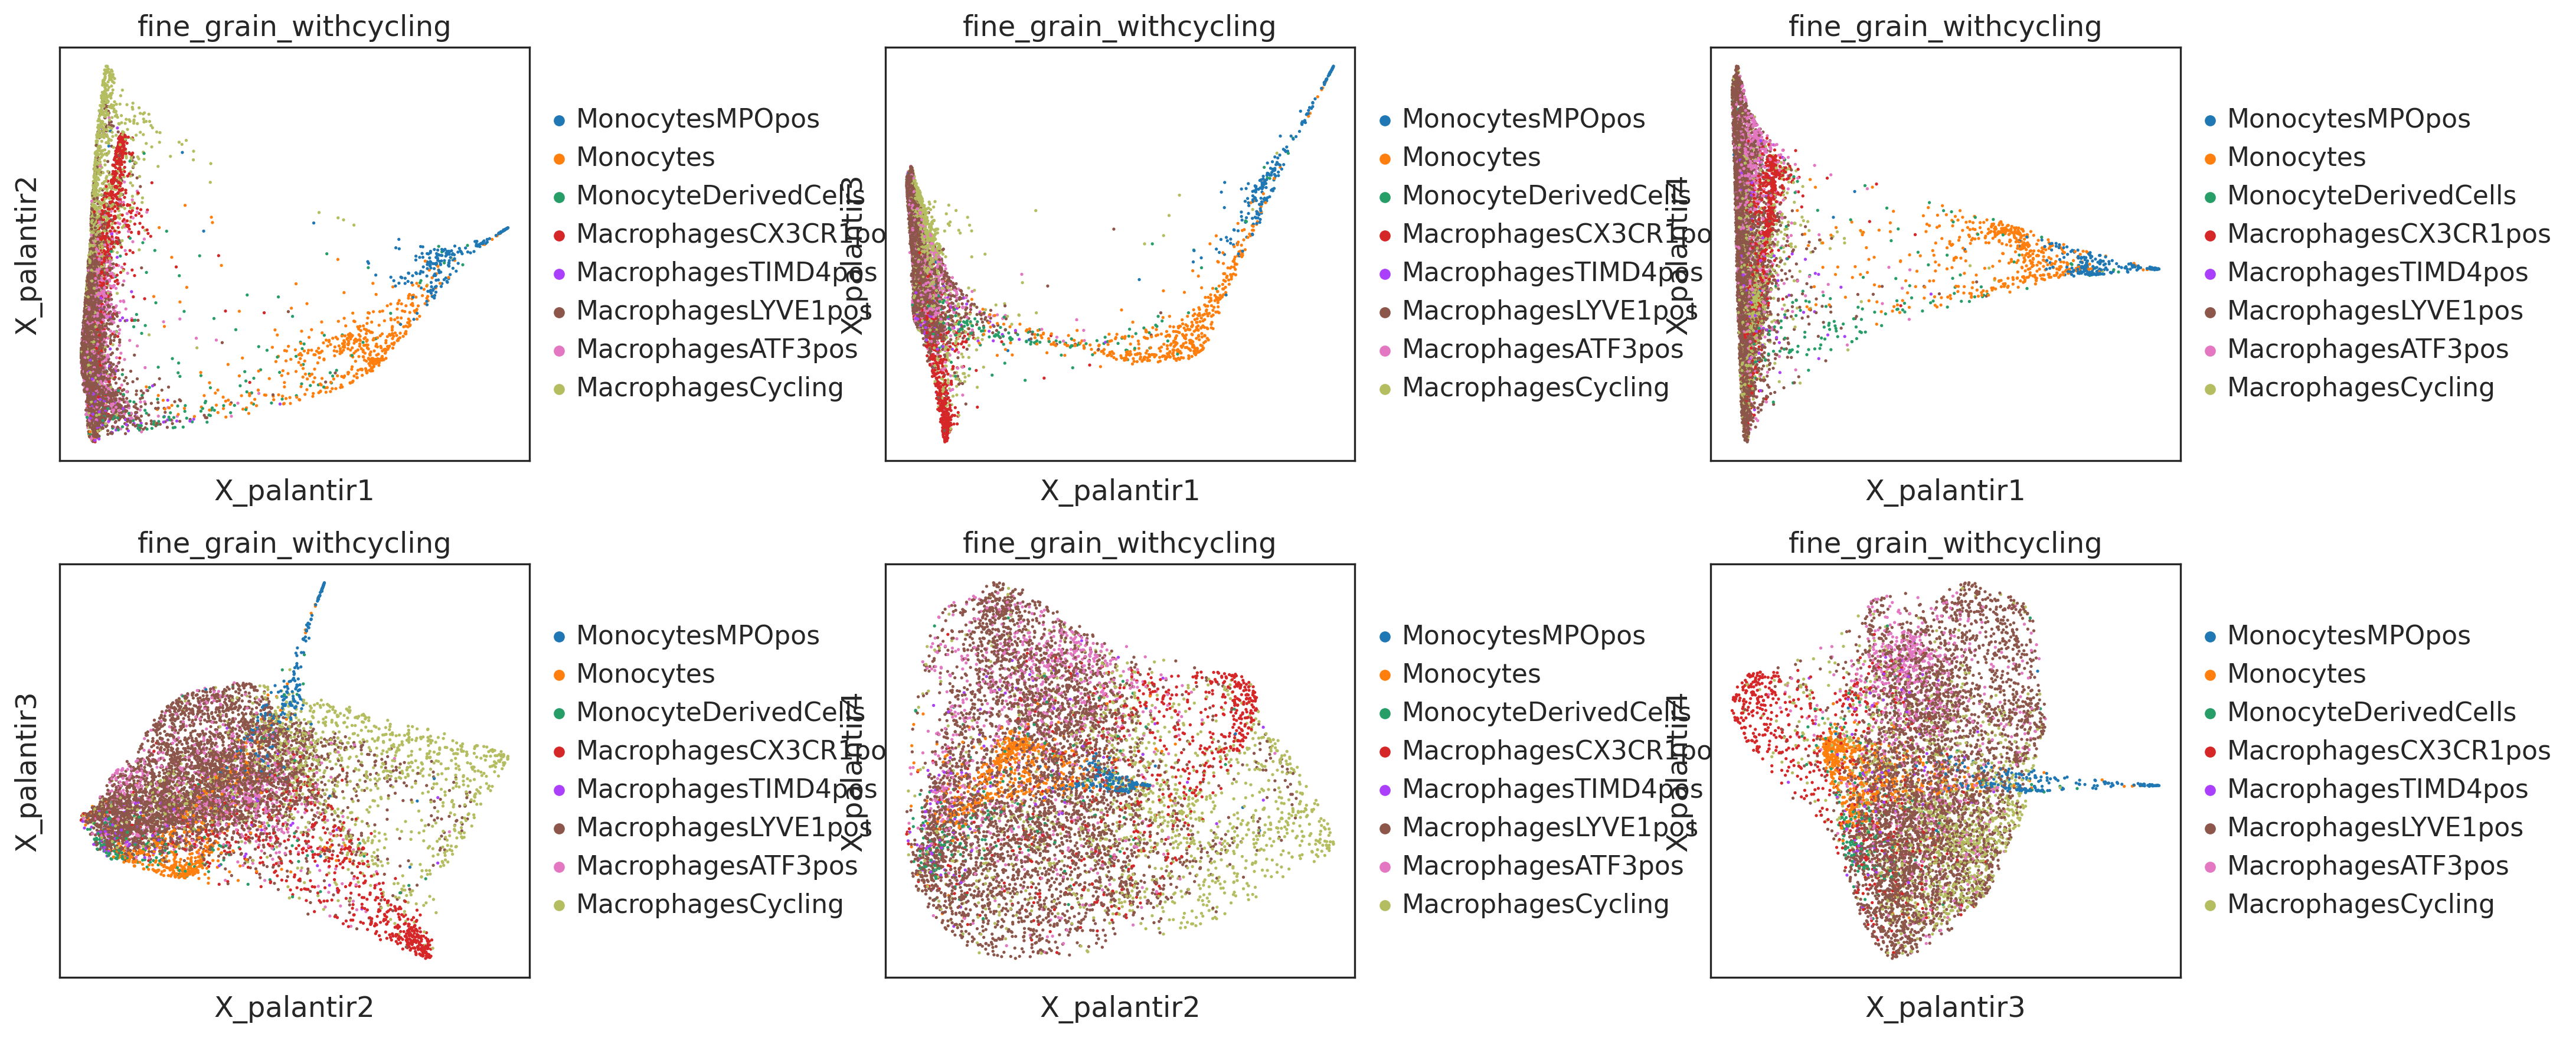

In [14]:
sc.pl.embedding(adata, basis='X_palantir',color=['fine_grain_withcycling'], components='all',ncols=3,wspace=0.6,size=10)

In [15]:
# draw ForceAtlas2 embedding using UMAP dim1 and dim2 as initial position
# make obsm with UMAP1 and 3
# since it looks well capturing the transition of Mono -> MoMP -> TRM and YS-MP -> TRM
adata.obsm['X_umap13'] = adata.obsm['X_umap'][:,[0,2]]
sc.tl.draw_graph(adata,init_pos='X_umap13',random_state=0)

### Plotting

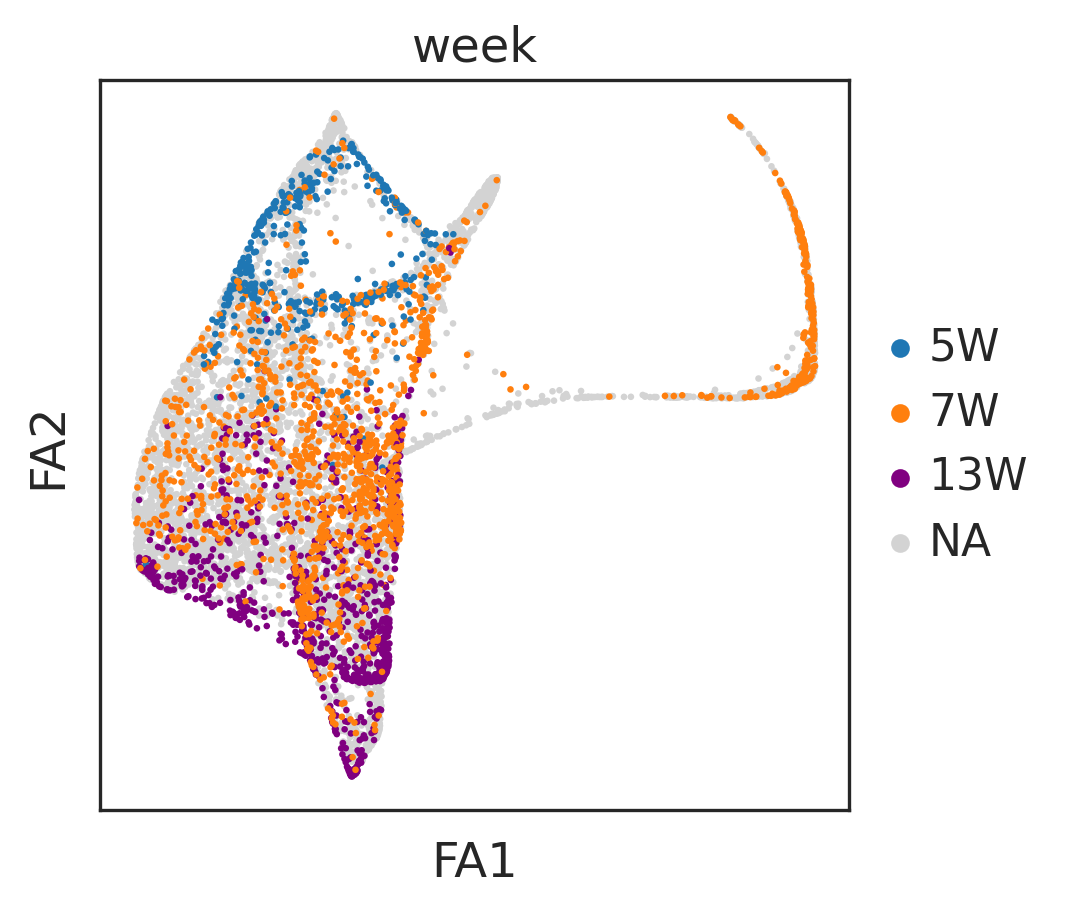

In [16]:
adata.uns["week_colors"][list(adata.obs['week'].cat.categories).index('13W')]='purple'
sc.pl.draw_graph(adata,color="week",groups=['5W','7W', '13W'],color_map="RdBu_r")

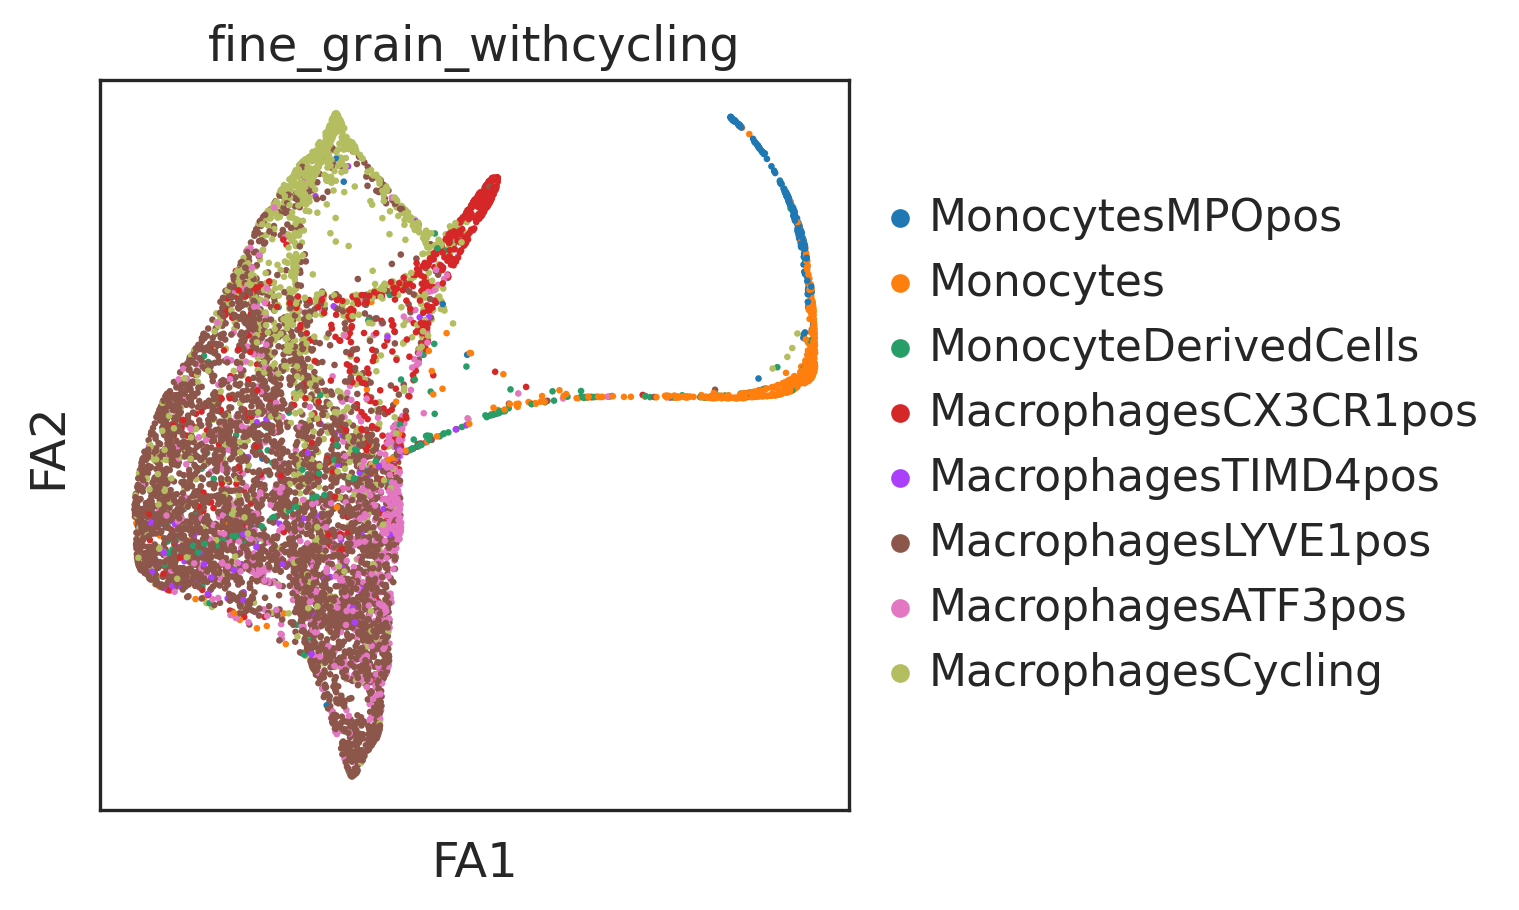

In [17]:
sc.pl.draw_graph(adata,color="fine_grain_withcycling",color_map="RdBu_r")

In [ ]:
adata

## Tree learning with SimplePPT (or ElPiGraph)

* User has the choice to running either ElPiGraph or SimplePPT algorithm to leanr a principal graph
* To get a "middle" of the data (nodes connected by edges)

In [18]:
scf.tl.tree(adata,method="ppt",Nodes=50,use_rep="palantir",
            device="cpu",seed=5)

inferring a principal tree --> parameters used 
    50 principal points, sigma = 0.1, lambda = 1, metric = euclidean
    fitting:  84%|████████▍ | 42/50 [00:04<00:00,  8.86it/s]
    converged
    finished (0:00:04) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


### Projecting results onto ForceAtlas2 embedding

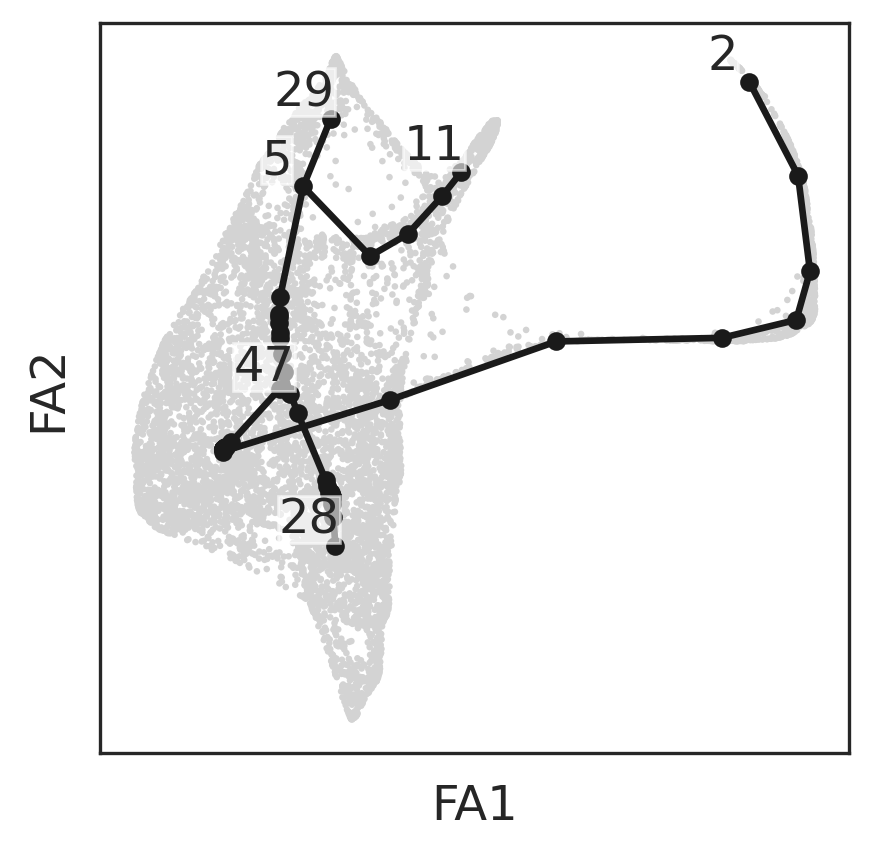

In [36]:
scf.pl.graph(adata,tips=False,forks=False,nodes=[2,5,29,11,47,28])

In [54]:
adata.uns['graph']['pp_seg']

n  from  to         d
1  1     2  47  4.077848
2  2     5  11  0.691825
3  3    29   5  0.182072
4  4     5  47  0.361574
5  5    32  16  0.008786
6  6    20  28  0.129682
7  7    20  32  0.031062
8  8    47  20  0.170317
9  9    32  44  0.000772

### Slecting roots and computing pseudotime

In [21]:
# Selecting a root and computing pseudotime
scf.tl.roots(adata,[29,2],meeting=47)
# generate 100 mappings of pseudotime, to account for cell asssignment uncertainty.
# .obs will be saved the mean of all calculated pseudotimes.
scf.tl.pseudotime(adata,n_jobs=20,n_map=1,seed=40)

root selected --> added
    2 is the farthest root.
    .uns['graph']['root'] farthest root selected.
    .uns['graph']['root2'] 2nd root selected.
    .uns['graph']['meeting'] meeting point on the tree.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:05) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


## Representing the trajectory and tree (on top of existing embedding)

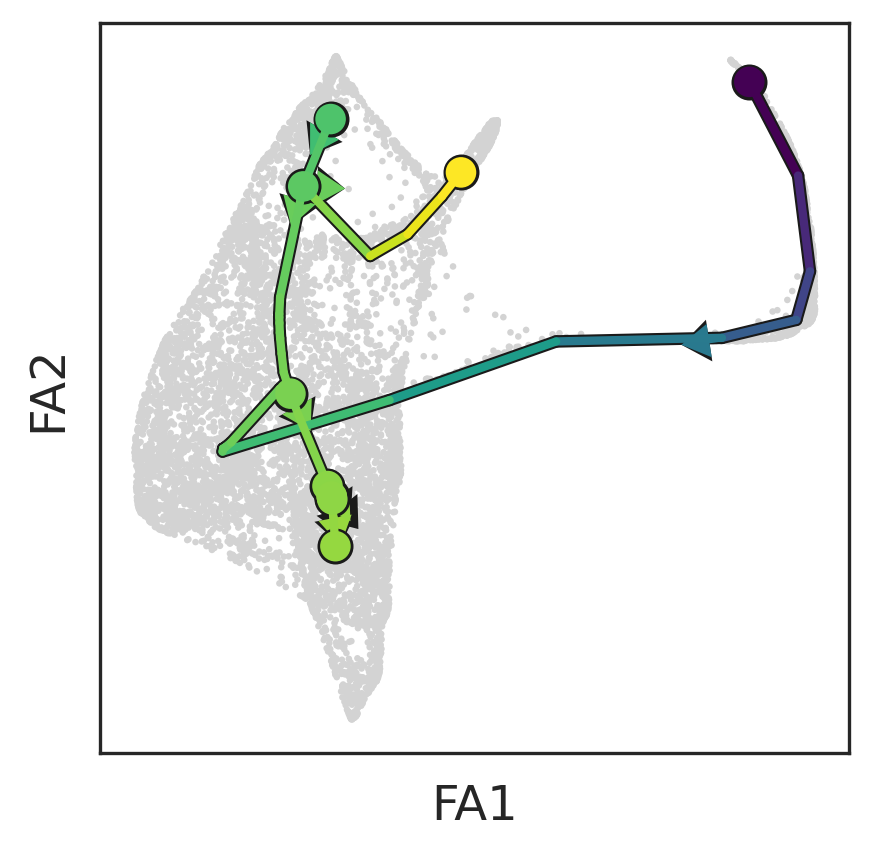

In [53]:
scf.pl.trajectory(adata,arrows=True,arrow_offset=3,scale_path=0.5,
                  # root_milestone=29,milestones=27
                 )

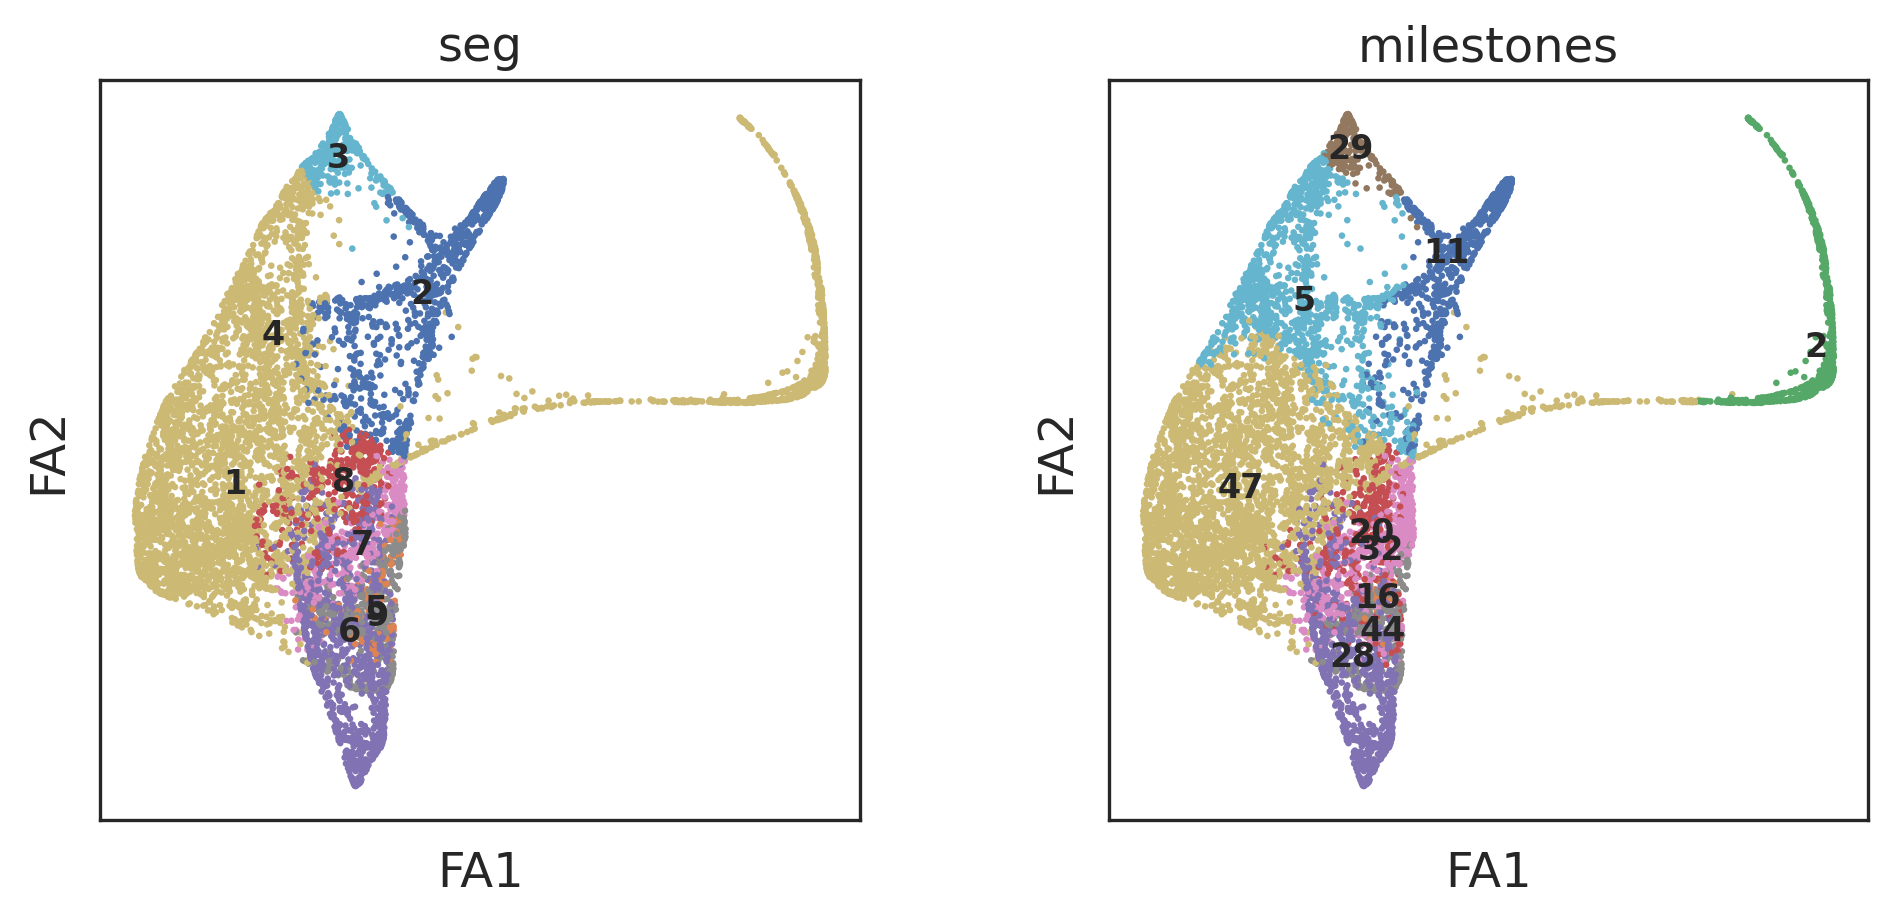

In [56]:
sc.pl.draw_graph(adata,color=["seg","milestones"],legend_loc='on data',legend_fontsize=10)
# scf.tl.rename_milestones(adata,["bifA","Ery","DC","Root","BifB","Mono"])
# we change the color of the root milestone for better visualisations
# adata.uns["milestones_colors"][3]="#17bece"

In [33]:
adata.uns['graph']['pp_seg']

n  from  to         d
1  1     2  47  4.077848
2  2     5  11  0.691825
3  3    29   5  0.182072
4  4     5  47  0.361574
5  5    32  16  0.008786
6  6    20  28  0.129682
7  7    20  32  0.031062
8  8    47  20  0.170317
9  9    32  44  0.000772

# Save the object

In [27]:
# save
adata.write('/nfs/team205/heart/anndata_objects/Foetal/Immune/MultiVI-post_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-0003.h5ad')

In [5]:
# read in
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/Immune/MultiVI-post_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-0003.h5ad')
adata

AnnData object with n_obs × n_vars = 7674 × 142283
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', '_indices', '_scvi_batch', '_scvi_labels', 'fine_grain_withcycling', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'draw_graph', 'fine_grain_colors', 'fine_grain_withcycling_colors', 'graph', 'milestones_colors', 'neighbors', 'p

# Plots for figure

In [15]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scipy
import scFates as scf
import matplotlib as mpl
import matplotlib.pyplot as plt
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [12]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [6]:
%matplotlib inline

In [7]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

In [10]:
# read in adata
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/Immune/MultiVI-post_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-0003.h5ad')
adata

AnnData object with n_obs × n_vars = 7674 × 142283
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', '_indices', '_scvi_batch', '_scvi_labels', 'fine_grain_withcycling', 't', 'seg', 'edge', 't_sd', 'milestones'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'adata_auc_gene', 'adata_auc_region', 'adata_gex', 'adata_gex_lognorm', 'draw_graph', 'fine_grain_colors', 'fine_

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


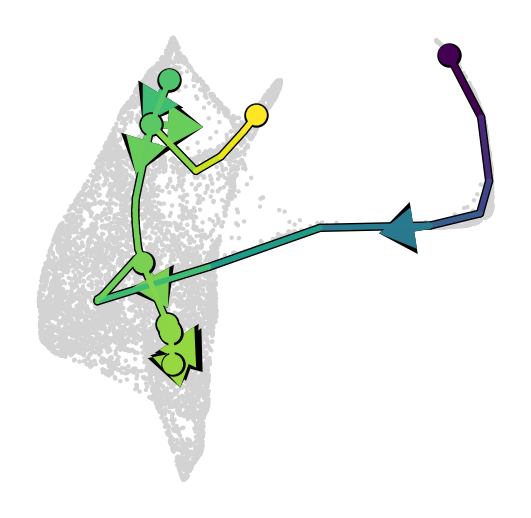

In [17]:
scf.pl.trajectory(adata,arrows=True,arrow_offset=3,scale_path=0.5, frameon=False,show=False)
plt.savefig(f"{figdir}/Force-directed-graph_MoMP_pseudotime.pdf", bbox_inches="tight",dpi=300)